**import sys:** Este comando importa el módulo sys, que proporciona acceso a las variables y funciones específicas del sistema y del intérprete Python.

**import warnings:** Este comando importa el módulo warnings, que permite controlar cómo se manejan las advertencias (warnings) emitidas por Python durante la ejecución de un programa.

**if not sys.warnoptions::** Esta línea verifica si la lista warnoptions en el módulo sys está vacía. La lista warnoptions generalmente contiene las opciones de advertencias configuradas por el usuario. Si esta lista está vacía, significa que el usuario no ha especificado ninguna opción de advertencia.

**warnings.simplefilter('ignore'):** Si la lista warnoptions está vacía, entonces se configura un filtro simple para las advertencias, ignorándolas. Esto significa que todas las advertencias generadas durante la ejecución del programa serán suprimidas y no se mostrarán en la salida estándar (como la consola). En otras palabras, se desactivan todas las advertencias en el programa.

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

**Corremos la data**

In [3]:
df = pd.read_csv('/content/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-17,99.519997,101.769997,99.510002,100.779999,100.779999,23311600
1,2022-10-18,103.940002,104.220001,100.650002,101.389999,101.389999,21610500
2,2022-10-19,100.699997,101.658997,99.635002,100.290001,100.290001,21573700
3,2022-10-20,100.820000,103.000000,99.970001,100.529999,100.529999,25125100
4,2022-10-21,98.459999,101.620003,98.230003,101.480003,101.480003,28988700


**minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')):** En esta línea, se crea una instancia de la clase MinMaxScaler de scikit-learn. Luego, se utiliza el método fit para calcular los valores mínimos y máximos necesarios para normalizar los datos. Se aplica a la columna de datos en df que está en el rango de índices de columna de 4 a 5 (excluyendo la columna 5). Se utiliza .astype('float32') para asegurarse de que los datos se interpreten como números de punto flotante de 32 bits antes de realizar el ajuste.

**df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')):** En esta línea, se utiliza el objeto minmax previamente creado para normalizar los datos en la misma columna de df que se seleccionó en la línea anterior. El método transform se utiliza para realizar la normalización, y el resultado se almacena en df_log.

**df_log = pd.DataFrame(df_log):** Aquí, los datos normalizados almacenados en df_log se convierten en un nuevo DataFrame de pandas. Esto puede ser útil si deseas realizar más manipulación o análisis de los datos normalizados utilizando las capacidades de pandas.

**df_log.head():** Finalmente, se utiliza el método .head() para mostrar las primeras filas del DataFrame df_log con los datos normalizados.

In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.297028
1,0.307507
2,0.288610
3,0.292733
4,0.309054


### Split train and test
I will cut the dataset to train and test datasets,

Train dataset derived from starting timestamp until last 30 days
Test dataset derived from last 30 days until end of the dataset
So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [5]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((250, 7), (220, 1), (30, 1))

**position_encoding(inputs):** Esta función parece estar generando una codificación de posición para una secuencia de datos. La codificación de posición se utiliza a menudo en modelos de atención y Transformers para inyectar información de posición en los datos secuenciales.

**layer_norm(inputs, epsilon=1e-8):** Esta función realiza una normalización por capas (layer normalization) en los datos de entrada inputs. La normalización por capas es una técnica utilizada en redes neuronales para estabilizar el entrenamiento y acelerar la convergencia.

**cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):** Esta función parece implementar un bloque de una red neuronal convolucional (CNN) con convoluciones dilatadas. Se aplica una capa de normalización por capas, luego se realizan convoluciones con dilatación y finalmente se aplica una función de activación ReLU.

**Model:** Esta es la definición de una clase de modelo. El constructor de la clase acepta varios hiperparámetros relacionados con la arquitectura del modelo, como el número de capas, el tamaño de las capas, el tamaño de salida, el tamaño del kernel, el número de cabezas de atención y la probabilidad de dropout. El modelo utiliza una serie de capas CNN con convoluciones dilatadas y cabezas de atención.

**calculate_accuracy(real, predict):** Esta función calcula la precisión (accuracy) entre dos conjuntos de datos, real y predict. Realiza una transformación en los datos y luego compara la diferencia entre los valores reales y predichos para calcular la precisión.

**anchor(signal, weight):** Esta función parece implementar un suavizado exponencial (exponential smoothing) en una serie de datos signal. El suavizado exponencial se utiliza para suavizar series temporales y reducir el ruido.

In [6]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.layers.dense(self.X, size_layer)
        encoder_embedded += position_encoding(encoder_embedded)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.variable_scope('block_%d'%i):
                encoder_embedded += cnn_block(encoder_embedded, dilation_rate,
                                              pad_sz, size_layer, kernel_size)

        encoder_output, output_memory = encoder_embedded, encoder_embedded + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.variable_scope('decode_%d'%i):
                attn_res = h = cnn_block(encoder_embedded, dilation_rate,
                                         pad_sz, size_layer, kernel_size)

            C = []
            for j in range(n_attn_heads):
                h_ = tf.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, keep_prob = dropout)
            encoder_embedded += h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

**num_layers:** Este hiperparámetro indica el número de capas en un modelo, como una red neuronal o un modelo de procesamiento de secuencias. En este caso, se ha configurado en 1, lo que significa que el modelo tiene una sola capa.

**size_layer:** Este hiperparámetro se refiere al tamaño de las capas ocultas en el modelo. Un valor de 128 implica que cada capa oculta tiene 128 unidades o neuronas.

**timestamp:** Este valor parece estar relacionado con el tamaño de las series temporales o secuencias de datos que se utilizan en el modelo. El nombre sugiere que es igual al tamaño de prueba (test_size).

**epoch:** Indica el número de épocas de entrenamiento que realizará el modelo. Una época completa corresponde a una pasada por todo el conjunto de datos de entrenamiento. En este caso, se han configurado 300 épocas.

**dropout_rate:** La probabilidad de dropout controla la cantidad de regularización que se aplica a un modelo. Un valor de 0.8 significa que se aplica dropout del 80% durante el entrenamiento, lo que ayuda a prevenir el sobreajuste.

**future_day:** Este valor podría estar relacionado con la cantidad de días en el futuro que el modelo se entrena para predecir. Parece estar configurado en el tamaño de prueba (test_size), lo que podría significar que el modelo se entrena para predecir datos futuros hasta el tamaño de prueba.

**learning_rate:** Este hiperparámetro determina la tasa de aprendizaje que controla el tamaño de los pasos de actualización de los pesos durante el entrenamiento del modelo. Un valor de 5e-4 (0.0005) sugiere una tasa de aprendizaje relativamente pequeña.

In [7]:
num_layers = 1
size_layer = 128
timestamp = test_size
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 5e-4

**num_layers:** Este hiperparámetro indica el número de capas en un modelo, como una red neuronal o un modelo de procesamiento de secuencias. En este caso, se ha configurado en 1, lo que significa que el modelo tiene una sola capa.

**size_layer**: Este hiperparámetro se refiere al tamaño de las capas ocultas en el modelo. Un valor de 128 implica que cada capa oculta tiene 128 unidades o neuronas.

**timestamp:** Este valor parece estar relacionado con el tamaño de las series temporales o secuencias de datos que se utilizan en el modelo. El nombre sugiere que es igual al tamaño de prueba (test_size).

**epoch:** Indica el número de épocas de entrenamiento que realizará el modelo. Una época completa corresponde a una pasada por todo el conjunto de datos de entrenamiento. En este caso, se han configurado 300 épocas.

**dropout_rate:** La probabilidad de dropout controla la cantidad de regularización que se aplica a un modelo. Un valor de 0.8 significa que se aplica dropout del 80% durante el entrenamiento, lo que ayuda a prevenir el sobreajuste.

**future_day:** Este valor podría estar relacionado con la cantidad de días en el futuro que el modelo se entrena para predecir. Parece estar configurado en el tamaño de prueba (test_size), lo que podría significar que el modelo se entrena para predecir datos futuros hasta el tamaño de prueba.

**learning_rate:** Este hiperparámetro determina la tasa de aprendizaje que controla el tamaño de los pasos de actualización de los pesos durante el entrenamiento del modelo. Un valor de 5e-4 (0.0005) sugiere una tasa de aprendizaje relativamente pequeña.

In [17]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import timedelta

def forecast():
    df = pd.read_csv("GOOG.csv")  # Asegúrate de cargar tus datos aquí

    learning_rate = 0.001
    num_layers = 2
    size_layer = 128
    dropout_rate = 0.8
    timestamp = 1
    epoch = 100
    test_size = 10

    df_log = df.copy()
    minmax = MinMaxScaler().fit(df_log.iloc[:, 4:5].astype('float32'))
    df_log = minmax.transform(df_log.iloc[:, 4:5].astype('float32'))
    df_train = df_log[: len(df) - test_size]

    modelnn = Sequential()
    modelnn.add(LSTM(size_layer, input_shape=(1, 1), return_sequences=True))
    modelnn.add(Dropout(dropout_rate))
    modelnn.add(Dense(1))

    modelnn.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = df_train[k:index, :]
            batch_y = df_train[k + 1:index + 1, :]
            batch_x = np.reshape(batch_x, (1, batch_x.shape[0], 1))
            batch_y = np.reshape(batch_y, (1, batch_y.shape[0], 1))
            modelnn.reset_states()
            loss = modelnn.train_on_batch(batch_x, batch_y)
            total_loss.append(loss)
        pbar.set_postfix(cost=np.mean(total_loss))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, 1))
    output_predict[0] = df_train[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = df_train[k:k + timestamp, :]
        batch_x = np.reshape(batch_x, (1, batch_x.shape[0], 1))
        modelnn.reset_states()
        out_logits = modelnn.predict_on_batch(batch_x)
        output_predict[k + 1:k + timestamp + 1] = out_logits[0]

    if upper_b != df_train.shape[0]:
        batch_x = df_train[upper_b:, :]
        batch_x = np.reshape(batch_x, (1, batch_x.shape[0], 1))
        modelnn.reset_states()
        out_logits = modelnn.predict_on_batch(batch_x)
        output_predict[upper_b + 1:df_train.shape[0] + 1] = out_logits[0]
        future_day -= 1

    init_value = np.zeros((1, num_layers * size_layer))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o = np.reshape(o, (1, o.shape[0], 1))
        modelnn.reset_states()
        out_logits = modelnn.predict_on_batch(o)
        output_predict[-future_day + i] = out_logits[0]

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = output_predict[:, 0]  # Cambia esto si es necesario

    return deep_future[-test_size:]


In [18]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 100/100 [04:21<00:00,  2.62s/it, cost=0.00475]


simulation 2


train loop: 100%|██████████| 100/100 [04:17<00:00,  2.58s/it, cost=0.00471]


simulation 3


train loop: 100%|██████████| 100/100 [04:27<00:00,  2.68s/it, cost=0.00472]


simulation 4


train loop: 100%|██████████| 100/100 [04:22<00:00,  2.62s/it, cost=0.00476]


simulation 5


train loop: 100%|██████████| 100/100 [04:20<00:00,  2.60s/it, cost=0.00477]


simulation 6


train loop: 100%|██████████| 100/100 [04:22<00:00,  2.63s/it, cost=0.00473]


simulation 7


train loop: 100%|██████████| 100/100 [04:15<00:00,  2.55s/it, cost=0.00472]


simulation 8


train loop: 100%|██████████| 100/100 [04:16<00:00,  2.57s/it, cost=0.0047]


simulation 9


train loop: 100%|██████████| 100/100 [04:16<00:00,  2.57s/it, cost=0.00476]


simulation 10


train loop: 100%|██████████| 100/100 [04:15<00:00,  2.55s/it, cost=0.00475]


**accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]:** Esta línea calcula la precisión de las predicciones hechas por el modelo en relación con los valores reales. Utiliza la función calculate_accuracy para comparar los valores reales con cada uno de los resultados en la lista results. La precisión se almacena en la lista accuracies.

**plt.figure(figsize=(15, 5)):** Se crea una nueva figura de matplotlib con un tamaño de 15 unidades de ancho y 5 unidades de alto para preparar el espacio para el gráfico.

**for no, r in enumerate(results)::** Se inicia un bucle que recorre los resultados en la lista results junto con un contador no.

**plt.plot(r, label='forecast %d'%(no + 1)):** Dentro del bucle, se traza la serie de predicciones r en el gráfico, y se etiqueta con el número de la predicción utilizando la cadena de formato 'forecast %d' % (no + 1).

**plt.plot(df['Close'].iloc[-test_size:].values, label='true trend', c='green'):** Se traza la serie de valores reales (tendencia real) en el gráfico y se etiqueta como "true trend". Estos valores se extraen de la columna 'Close' de df para los últimos test_size días.

**plt.legend():** Se agrega una leyenda al gráfico que muestra las etiquetas de las series trazadas.

**plt.title('average accuracy: %.4f'%(np.mean(accuracies)):** Se agrega un título al gráfico que muestra la precisión promedio de las predicciones calculada previamente en la lista accuracies.

**plt.show():** Se muestra el gráfico en una ventana o en la salida de la consola.

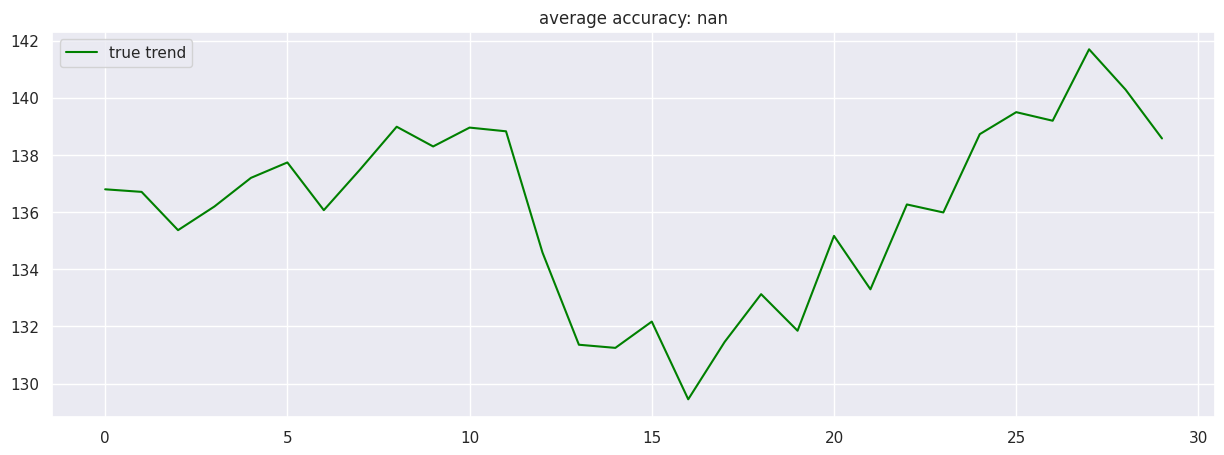

In [24]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'green')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()